In [1]:
import pandas as pd
from pycaret.classification import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#1. cargamos la data
df = pd.read_csv('caso2_microcredito_default.csv')

In [3]:
df.head()

,zona,tipo_negocio,monto_credito,cuotas_pagadas,mujer_emprendedora,hijos,default
0,Selva,Servicios,4027,10,0,3,0
1,Costa,Comercio,557,6,1,4,0
2,Costa,Agrícola,4925,1,1,4,0
3,Sierra,Ganadero,3901,8,0,4,0
4,Sierra,Servicios,2362,6,0,0,0


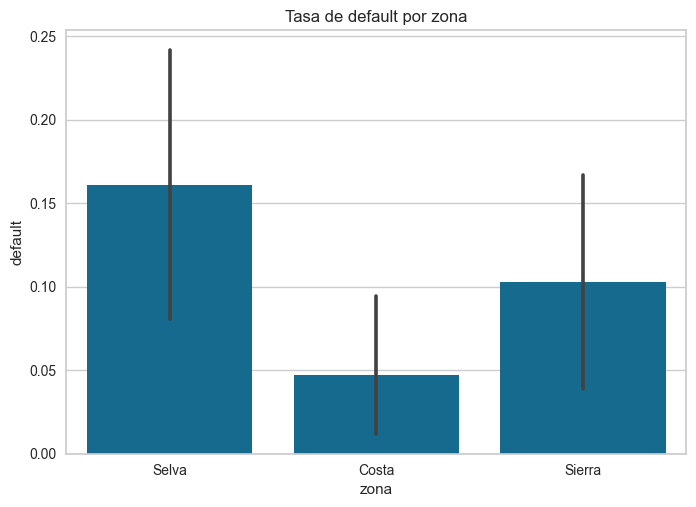

In [4]:
#2. Analisis exploratorio no trivial: identificar patrones por zona
sns.barplot(x='zona', y='default', data=df)
plt.title("Tasa de default por zona")
plt.show()

In [ ]:
# 3. Segmentar por negocios donde el default es mayor
df_seg = df[df['tipo_negocio'].isin(['Agricola','Comercio'])]

In [6]:
print(df_seg['default'].value_counts())

default
0    61
1     7
Name: count, dtype: int64


In [ ]:
# 4. Configurar PyCaret con enfoque segmentado
from imblearn.over_sampling import RandomOverSampler
exp =setup(data=df_seg,
           target='default',
           session_id=999,
           categorical_features=['zona','tipo_negocio'],
           ignore_features=['cuotas_pagadas'],
           remove_multicollinearity=True,
           multicollinearity_threshold=0.8,
           normalize=True,
           fix_imbalance=True,
           fix_imbalance_method=RandomOverSampler()
           )

,Description,Value
0,Session id,999
1,Target,default
2,Target type,Binary
3,Original data shape,"(68, 7)"
4,Transformed data shape,"(105, 8)"
5,Transformed train set shape,"(84, 8)"
6,Transformed test set shape,"(21, 8)"
7,Ignore features,1
8,Numeric features,3
9,Categorical features,2


In [13]:
# 5. Buscar el mejor modelo considerando AUC y Recal
best=compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4400,0.3000,0.2000,0.0533,0.0833,-0.0442,-0.0408,0.0130
ridge,Ridge Classifier,0.6500,0.4000,0.2000,0.0833,0.1167,nan,0.0771,0.0130
lda,Linear Discriminant Analysis,0.6500,0.4000,0.2000,0.0833,0.1167,nan,0.0771,0.0130
lightgbm,Light Gradient Boosting Machine,0.7500,0.3875,0.2000,0.2000,0.2000,nan,0.1750,0.0290
lr,Logistic Regression,0.6750,0.4000,0.1000,0.1000,0.1000,nan,0.0500,0.4480
dt,Decision Tree Classifier,0.8250,0.3000,0.1000,0.1000,0.1000,nan,0.1000,0.0120
svm,SVM - Linear Kernel,0.7150,0.3750,0.1000,0.1000,0.1000,nan,0.0750,0.0130
rf,Random Forest Classifier,0.7800,0.3250,0.1000,0.1000,0.1000,nan,0.1000,0.0370
gbc,Gradient Boosting Classifier,0.8400,0.2250,0.1000,0.1000,0.1000,nan,0.0500,0.0260
knn,K Neighbors Classifier,0.6350,0.2375,0.0000,0.0000,0.0000,nan,-0.0750,0.2570


In [15]:
print(best)

GaussianNB(priors=None, var_smoothing=1e-09)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.4000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.2000,1.0000,1.0000,0.2000,0.3333,0.0000,0.0000
3,0.4000,0.5000,0.0000,0.0000,0.0000,-0.3636,-0.4082
4,0.8000,0.7500,1.0000,0.5000,0.6667,0.5455,0.6124
5,0.8000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.4000,0.2500,0.0000,0.0000,0.0000,-0.3636,-0.4082
7,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


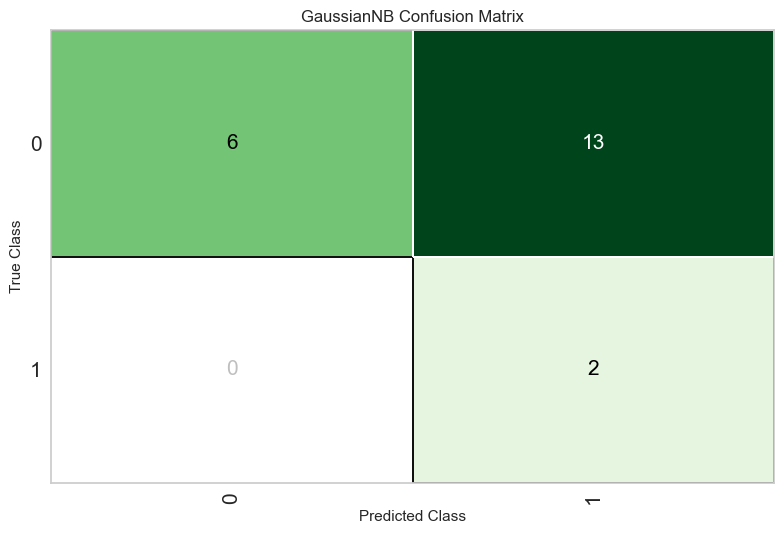

In [9]:
# 6. Evalucion de sensibilidad para reducir falsos negativos
final_model = tune_model(best, optimize='Recall')
plot_model(final_model, plot='confusion_matrix')

In [12]:
#8. simular nuevo criterio (no usar el df)
nuevo_cliente = pd.DataFrame({
    'zona':['Selva'],
    'tipo_negocio': ['Agricola'],
    'monto_credito': [4500],
    'mujer_emprendedora':[1],
    'hijos':[3]
    }
)
pred =predict_model(final_model, data=nuevo_cliente)
print(pred)

    zona tipo_negocio  monto_credito  mujer_emprendedora  hijos  \
0  Selva     Agricola           4500                   1      3   

   prediction_label  prediction_score  
0                 1               1.0  


In [14]:
# 9. Guardar para pipeline rural
save_model(final_model, 'modelo_default_rural_selva')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['monto_credito',
                                              'mujer_emprendedora', 'hijos'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     includ...
                  TransformerWrapper(exclude=None, include=None,
                               